In [1]:
import os
import torch
import mlflow
import gc
import time
from torch.utils.data import DataLoader

from MED.modeling.modeling_utils import train_single_epoch_COG_Sequential, validate_single_epoch_COG_Sequential, retrieve_results_mlflow, retrieve_results_mlflow_sequential, create_summary_df, \
            define_model_objects, compute_window_metrics, create_binary_mask

from MED.dataset.dataset_utils import compute_window_size_stride
from MED.dataset.CustomFrameDataset import CustomFrameDataset
from MED.visualization.utils import plot_results_LOSO, plot_cm

In [2]:
#def main(): #Main loop for training.
cuda = False
if cuda:
    torch.cuda.empty_cache() # Clear cache
    
else:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    torch.mps.empty_cache()

settings = ['LOSO']#, 'LOUO']
tasks = ['All', 'Suturing','Knot_Tying','Needle_Passing']
out1 = ['Bout','Cout','Dout','Eout','Fout','Gout','Hout','Iout']
out2 = ['1out', '2Out', '3out','4out','5out']

exp_kwargs = {
    'error_type': 'all_errors', # 'all_errors' or 'global'
    'dataset_type': 'frame', #"frame" or "window"
    'save_local': False,
    'pos_weight': False,  
    'use_COG_video': True,
    'n_epochs': 5,
    'batch_size': 1,
    'frequency': 5,
    'lr': 5e-4,
    'lr_scheduler': False, 
    'weight_decay': 0, 
    'out_features': 5, #number of error classes
    'mstcn_causal_conv': True, #default True
    'mstcn_layers': 8, #8 for TeCNo, TransSVNet, COG
    'mstcn_f_maps': 64, #64 for TeCNo, TransSVNet, COG
    'mstcn_stages': 8, #2 for TeCNo, TransSVNet, 8 for COG
    'num_R': 3, #3 for COG, not used otherwise
    'num_layers_R': 10, #10 for COG, not used otherwise
    'num_layers_Basic': 11, #11 for COG, not used otherwise
    'd_model': 64, #64 for COG, not used otherwise
    'd_q': 8, #8 for COG, not used otherwise
    'lambda': 0, #default 0.15 for COG
    'sequence_length': 30, #default 30 in repo, but afraid of "10" I've written somewhere (same for all)
    'model_name': 'COG', #'TeCNo' or 'TransSVNet' or 'COG'
    'video_dims': 32, #32 default
    'loss_or_f1': 'f1',  #'loss' or 'f1' to determine the metric for validation
    'data_type': 'multimodal', #'multimodal' or 'video' or 'kinematics'
    'run_id': "9c1ba48e057a4702994c14dca0dd3e0f", #binary model run ID
    'delete_ND': True, #delete ND frames in this framework
    'compute_from_str': False,
    'use_true_binary_labels_train': True #use true binary labels for training, not the predicted ones
}

exp_kwargs_binary = {
    'error_type': 'global',
    'model_name': "COG",
    'dataset_type': "frame",
    'save_local': False,
    'return_train_preds': True,
    "compute_from_str": False}

best_model = None
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

#Set up folders to save results and images
results_folder = f"results/{exp_kwargs['data_type']}_ES_sequential/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/"
image_folder = f"images/{exp_kwargs['data_type']}_ES_sequential/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/" 

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if not os.path.exists(image_folder):
    os.makedirs(image_folder)

#Define in_features
in_features_dict = {
    'multimodal': exp_kwargs['video_dims'] + 26,
    'video': exp_kwargs['video_dims'],
    'kinematics': 26
}
exp_kwargs['mstcn_f_dim'] = in_features_dict[exp_kwargs['data_type']] 


#Retrieve binary model results
binary_f1_train, binary_f1_test, binary_acc_train, binary_acc_test, binary_jaccard_train, binary_jaccard_test, binary_cm_train, binary_cm_test, \
train_all_preds, train_all_probs, train_all_labels, train_all_subjects, test_all_preds_binary, test_all_probs_binary,\
test_all_labels_binary, test_all_labels_specific_binary, test_all_gest_labels_binary, test_all_subjects_binary = retrieve_results_mlflow(outs=['1out', '2Out', '3out', '4out', '5out'],
                                                                                                                   setting=settings[0],
                                                                                                                   exp_kwargs=exp_kwargs_binary,   
                                                                                                                    run_id=exp_kwargs['run_id'])

Loading data for LOSO with trial 1out...
(25484,)
Found mask_position_ND for subject Suturing_H003 in 1out set.
(25458,)
(8332,)
Found mask_position_ND for subject Needle_Passing_D001 in 1out set.
(8303,)
Number of parameters to optimize: 2783309


100%|██████████| 54/54 [01:14<00:00,  1.38s/it]


Epoch 1/5, F1: 0.2826, Specific F1: 0.1392, Accuracy: 0.6174, Specific Accuracy: 0.2408, Jaccard: 0.2342, Specific Jaccard: 0.0811, Loss: 1.6372, Time: 74.63 seconds


100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


New best F1 score: 0.07728045325779037 at epoch 1, with weighted F1 score: 0.09253031798071108


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


New best F1 score: 0.13400460849688697 at epoch 2, with weighted F1 score: 0.18808405955393245


100%|██████████| 54/54 [00:34<00:00,  1.58it/s]


Epoch 5/5, F1: 0.2514, Specific F1: 0.1017, Accuracy: 0.5681, Specific Accuracy: 0.1430, Jaccard: 0.2126, Specific Jaccard: 0.0552, Loss: 0.7475, Time: 34.21 seconds


100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Inference rate: 16.0643 ms per frame.


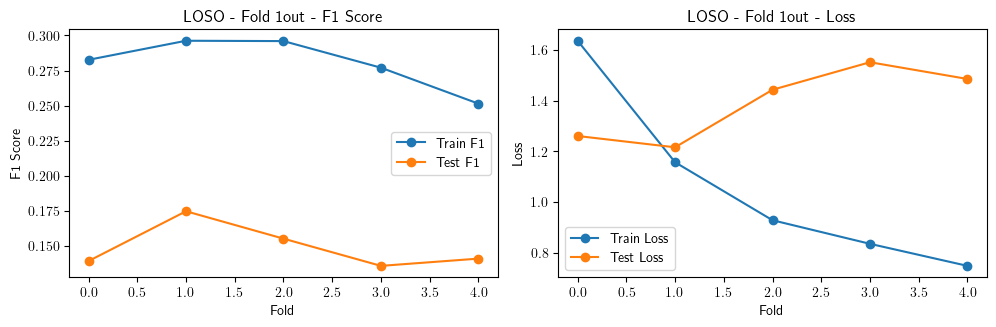

Loading data for LOSO with trial 2Out...
(27760,)
Found mask_position_ND for subject Needle_Passing_D001 in 2Out set.
Found mask_position_ND for subject Suturing_H003 in 2Out set.
(27705,)
(6056,)
(6056,)
Number of parameters to optimize: 2783309


100%|██████████| 55/55 [00:49<00:00,  1.12it/s]


Epoch 1/5, F1: 0.2960, Specific F1: 0.1552, Accuracy: 0.5968, Specific Accuracy: 0.2436, Jaccard: 0.2419, Specific Jaccard: 0.0903, Loss: 1.5202, Time: 49.15 seconds


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


New best F1 score: 0.10011280605929689 at epoch 1, with weighted F1 score: 0.09805764255553166


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


New best F1 score: 0.11234382220965974 at epoch 2, with weighted F1 score: 0.16181860712335494


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


New best F1 score: 0.12006753544687995 at epoch 3, with weighted F1 score: 0.2373575402887025


100%|██████████| 55/55 [00:37<00:00,  1.48it/s]


Epoch 5/5, F1: 0.2559, Specific F1: 0.1071, Accuracy: 0.5531, Specific Accuracy: 0.1616, Jaccard: 0.2155, Specific Jaccard: 0.0586, Loss: 0.7305, Time: 37.17 seconds


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


New best F1 score: 0.1287264633799185 at epoch 5, with weighted F1 score: 0.30386269904479646
Inference rate: 8.6106 ms per frame.


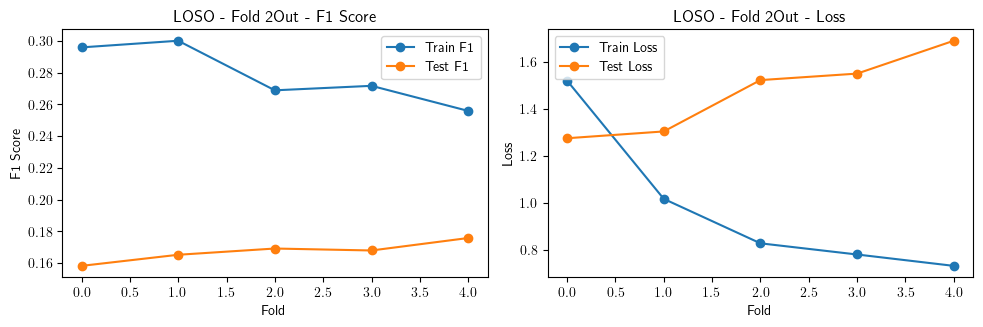

Loading data for LOSO with trial 3out...
(26750,)
Found mask_position_ND for subject Needle_Passing_D001 in 3out set.
(26721,)
(7066,)
Found mask_position_ND for subject Suturing_H003 in 3out set.
(7040,)
Number of parameters to optimize: 2783309


100%|██████████| 53/53 [00:36<00:00,  1.47it/s]


Epoch 1/5, F1: 0.3058, Specific F1: 0.1670, Accuracy: 0.6008, Specific Accuracy: 0.2664, Jaccard: 0.2487, Specific Jaccard: 0.0985, Loss: 1.6429, Time: 36.18 seconds


100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


New best F1 score: 0.1452541735739536 at epoch 1, with weighted F1 score: 0.3188828188858815


100%|██████████| 53/53 [00:35<00:00,  1.49it/s]


Epoch 5/5, F1: 0.2629, Specific F1: 0.1155, Accuracy: 0.5480, Specific Accuracy: 0.1693, Jaccard: 0.2196, Specific Jaccard: 0.0635, Loss: 0.7486, Time: 35.68 seconds


100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


Inference rate: 10.6413 ms per frame.


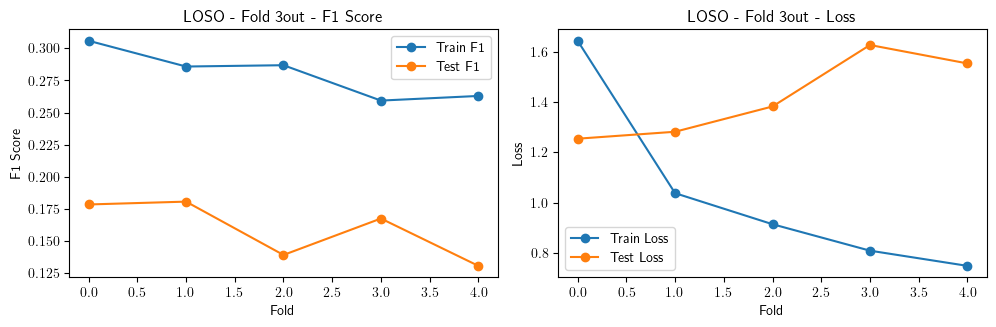

Loading data for LOSO with trial 4out...
(26887,)
Found mask_position_ND for subject Needle_Passing_D001 in 4out set.
Found mask_position_ND for subject Suturing_H003 in 4out set.
(26832,)
(6929,)
(6929,)
Number of parameters to optimize: 2783309


100%|██████████| 52/52 [00:35<00:00,  1.47it/s]


Epoch 1/5, F1: 0.2905, Specific F1: 0.1486, Accuracy: 0.5642, Specific Accuracy: 0.2192, Jaccard: 0.2372, Specific Jaccard: 0.0846, Loss: 1.5570, Time: 35.38 seconds


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


New best F1 score: 0.07530917814227772 at epoch 1, with weighted F1 score: 0.10710402727844551


100%|██████████| 52/52 [00:34<00:00,  1.50it/s]


Epoch 5/5, F1: 0.2414, Specific F1: 0.0897, Accuracy: 0.5115, Specific Accuracy: 0.1247, Jaccard: 0.2067, Specific Jaccard: 0.0480, Loss: 0.7243, Time: 34.64 seconds


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


Inference rate: 12.0892 ms per frame.


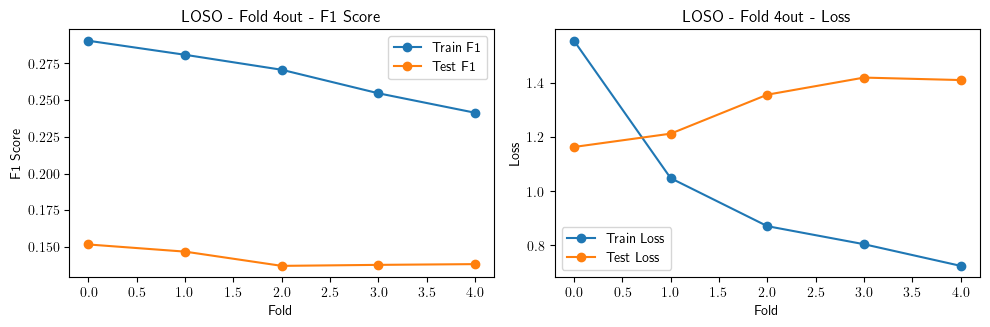

Loading data for LOSO with trial 5out...
(28383,)
Found mask_position_ND for subject Needle_Passing_D001 in 5out set.
Found mask_position_ND for subject Suturing_H003 in 5out set.
(28328,)
(5433,)
(5433,)
Number of parameters to optimize: 2783309


100%|██████████| 54/54 [00:36<00:00,  1.46it/s]


Epoch 1/5, F1: 0.2923, Specific F1: 0.1507, Accuracy: 0.5719, Specific Accuracy: 0.2373, Jaccard: 0.2391, Specific Jaccard: 0.0869, Loss: 1.6877, Time: 36.95 seconds


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


New best F1 score: 0.12797233222487064 at epoch 1, with weighted F1 score: 0.16783503313691356


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


New best F1 score: 0.10607171129904432 at epoch 3, with weighted F1 score: 0.17933602753768682


100%|██████████| 54/54 [00:36<00:00,  1.48it/s]


Epoch 5/5, F1: 0.2632, Specific F1: 0.1159, Accuracy: 0.5385, Specific Accuracy: 0.1779, Jaccard: 0.2205, Specific Jaccard: 0.0645, Loss: 0.7542, Time: 36.53 seconds


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Inference rate: 8.8497 ms per frame.


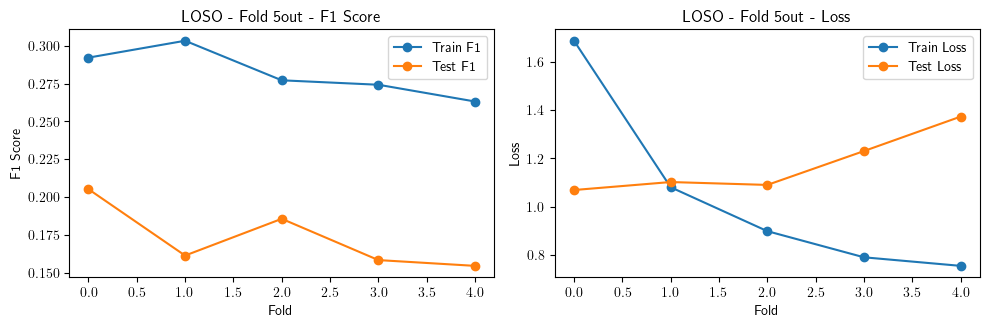

🏃 View run wistful-jay-689 at: http://127.0.0.1:8080/#/experiments/587050325947151693/runs/f32797cfb1ee4566bff78ca230342bde
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/587050325947151693


In [ ]:
mlflow.set_experiment(f"{exp_kwargs['model_name']}_{exp_kwargs['data_type']}_sequential_ES")

#Ensure seed is set for reproducibility
torch.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

samples_train, samples_test, inference_rates, train_times = [], [], [], []
with mlflow.start_run() as run:
    
    #Log the hyperparameters
    if not exp_kwargs['save_local']:
        mlflow.log_params(exp_kwargs)
        run_id = run.info.run_id

    for setting in settings:

        if setting == 'LOSO':
            outs = out2
        else:
            outs = out1

        for out in outs:

            #Delete device and RAM memory
            if cuda:
                torch.cuda.empty_cache()
            else:
                torch.mps.empty_cache()
                
            #Initialize lists to store results for each fold
            train_loss_fold, train_f1_fold, train_f1_fold_specific, train_accuracy_fold, \
                train_accuracy_fold_specific, train_jaccard_fold, train_jaccard_fold_specific, \
                train_cm_fold, train_cm_fold_specific, test_loss_fold, test_f1_fold, test_f1_fold_specific, \
                test_accuracy_fold, test_accuracy_fold_specific, test_jaccard_fold, \
                test_jaccard_fold_specific, test_cm_fold, test_cm_fold_specific, train_times_fold = ([] for _ in range(19))

            best_f1 = 0.0
            best_loss = float('inf')    
            save_best = False

            #a. Load training and testing data
            print(f"Loading data for {setting} with trial {out}...")
            fold_data_path = f"data/LOSO/{exp_kwargs['frequency']}Hz/" + out + '/'
            video_data_path = f"../Chain-of-Gesture/dataset/setting_f1/LOSO/All/{out}"
            #video_data_path = None
            
            #b. Retrieve dataloaders
            train_dataset = CustomFrameDataset(fold_data_path=fold_data_path,
                                                video_data_path=video_data_path,
                                                    csv_filename='train.csv',
                                                    delete_ND=exp_kwargs['delete_ND'])
            
            test_dataset = CustomFrameDataset(fold_data_path=fold_data_path,
                                                video_data_path=video_data_path,
                                                csv_filename='test.csv',
                                                delete_ND=exp_kwargs['delete_ND'])
            
            train_dataloader = DataLoader(train_dataset, 
                                        batch_size=exp_kwargs['batch_size'], 
                                        shuffle=True,
                                        generator=torch.Generator().manual_seed(42))
            
            samples_train.append(len(train_dataloader.dataset))
            
            test_dataloader = DataLoader(test_dataset,
                                        batch_size=exp_kwargs['batch_size'], 
                                        shuffle=False,
                                        generator=torch.Generator().manual_seed(42))  
            
            # b.2. Load binary mask and subjects
            if exp_kwargs['use_true_binary_labels_train']:
                binary_mask_train, binary_subjects_train = create_binary_mask(preds_binary=train_all_labels,
                                                                            subjects=train_all_subjects,
                                                                            out=out,
                                                                            fold_data_path=fold_data_path)
            else:
                binary_mask_train, binary_subjects_train = create_binary_mask(preds_binary=train_all_preds,
                                                                           subjects=train_all_subjects,
                                                                           out=out,
                                                                           fold_data_path=fold_data_path)
            
            binary_mask_test, binary_subjects_test = create_binary_mask(preds_binary=test_all_preds_binary,
                                                                           subjects=test_all_subjects_binary,
                                                                           out=out,
                                                                           fold_data_path=fold_data_path)

        
            #c. Define model objects
            feature_extractor, model, criterion, optimizer, scheduler = define_model_objects(exp_kwargs=exp_kwargs,
                                                                                                in_features_dict=in_features_dict,
                                                                                                window_size=0,
                                                                                                device=device,
                                                                                                class_counts=[])

            model_folder = f'models/{exp_kwargs["data_type"]}_ES_sequential/{exp_kwargs["frequency"]}Hz/{model.name}/'       

            #d. Training loop
            for epoch in range(exp_kwargs['n_epochs']):
                
                train_start = time.time()
        
                train_average_loss, train_f1_all, train_f1_error_specific, train_f1_error_specific_weighted, train_accuracy_all, train_accuracy_error_specific, \
                train_jaccard_all, train_jaccard_error_specific, train_jaccard_error_specific_weighted, train_cm_all, train_cm_error_specific = train_single_epoch_COG_Sequential(model=model,
                                                            feature_extractor=feature_extractor,
                                                            train_dataloader=train_dataloader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            device=device,
                                                            binary_mask=binary_mask_train,
                                                            binary_subjects=binary_subjects_train,
                                                            exp_kwargs=exp_kwargs,
                                                            scheduler=scheduler)
                    
                    
                train_end = time.time()
                train_times_fold.append(train_end - train_start)

                if epoch % 5 == 0 or epoch == exp_kwargs['n_epochs'] - 1:
                    print(f"Epoch {epoch + 1}/{exp_kwargs['n_epochs']}, F1: {train_f1_all:.4f}, "
                          f"Specific F1: {train_f1_error_specific:.4f}, "
                          f"Accuracy: {train_accuracy_all:.4f}, "
                          f"Specific Accuracy: {train_accuracy_error_specific:.4f}, "
                          f"Jaccard: {train_jaccard_all:.4f}, "
                          f"Specific Jaccard: {train_jaccard_error_specific:.4f}, "
                          f"Loss: {train_average_loss:.4f}, "
                          f"Time: {train_end - train_start:.2f} seconds")

                #Append to vectors
                train_loss_fold.append(train_average_loss)
                train_f1_fold.append(train_f1_all)
                train_f1_fold_specific.append(train_f1_error_specific)
                train_accuracy_fold.append(train_accuracy_all)
                train_accuracy_fold_specific.append(train_accuracy_error_specific)
                train_jaccard_fold.append(train_jaccard_all)
                train_jaccard_fold_specific.append(train_jaccard_error_specific)
                train_cm_fold.append(train_cm_all.tolist())
                train_cm_fold_specific.append(train_cm_error_specific.tolist())

                #e. Validation loop
                test_average_loss, test_f1_all, test_f1_error_specific, test_f1_error_specific_weighted, test_accuracy_all, test_accuracy_error_specific, \
                test_jaccard_all, test_jaccard_error_specific, test_jaccard_error_specific_weighted, test_cm_all, test_cm_error_specific, \
                inference_rate, test_preds_all, test_preds_error_specific, test_probs_error_specific, \
                test_labels_all, test_labels_error_specific, test_gest_labels, test_subjects = validate_single_epoch_COG_Sequential(model=model,
                                                        feature_extractor=feature_extractor,
                                                        test_dataloader=test_dataloader,
                                                        criterion=criterion,
                                                        binary_mask=binary_mask_test,
                                                        binary_subjects=binary_subjects_test,
                                                        device=device,
                                                        exp_kwargs=exp_kwargs)

                #Append to vectors
                test_loss_fold.append(test_average_loss)
                test_f1_fold.append(test_f1_all)
                test_f1_fold_specific.append(test_f1_error_specific)
                test_accuracy_fold.append(test_accuracy_all)
                test_accuracy_fold_specific.append(test_accuracy_error_specific)
                test_jaccard_fold.append(test_jaccard_all)
                test_jaccard_fold_specific.append(test_jaccard_error_specific)
                test_cm_fold.append(test_cm_all.tolist())
                test_cm_fold_specific.append(test_cm_error_specific.tolist())

                if exp_kwargs['loss_or_f1'] == 'loss':
                    if test_average_loss < best_loss:
                        save_best = True
                        best_loss = test_average_loss
                        print(f"New best loss: {test_average_loss} at epoch {epoch + 1}")

                elif exp_kwargs['loss_or_f1'] == 'f1':
                    if test_f1_error_specific_weighted > best_f1:
                        save_best = True
                        best_f1 = test_f1_error_specific_weighted
                        print(f"New best F1 score: {test_f1_error_specific} at epoch {epoch + 1}, with weighted F1 score: {test_f1_error_specific_weighted}")

                if save_best:
                    
                    best_model = {
                        'feature_extractor': feature_extractor,
                        'model': model,
                        'epoch': epoch + 1,
                        'train_loss': train_average_loss,
                        'test_loss': test_average_loss,
                        'train_f1': train_f1_all,
                        'test_f1': test_f1_all, 
                        'train_f1_specific': train_f1_error_specific,
                        'train_f1_specific_weighted': train_f1_error_specific_weighted,
                        'test_f1_specific': test_f1_error_specific,
                        'test_f1_specific_weighted': test_f1_error_specific_weighted,
                        'train_accuracy': train_accuracy_all,
                        'test_accuracy': test_accuracy_all,
                        'train_accuracy_specific': train_accuracy_error_specific,
                        'test_accuracy_specific': test_accuracy_error_specific,
                        'train_jaccard': train_jaccard_all,
                        'test_jaccard': test_jaccard_all,
                        'train_jaccard_specific': train_jaccard_error_specific,
                        'train_jaccard_specific_weighted': train_jaccard_error_specific_weighted,
                        'test_jaccard_specific': test_jaccard_error_specific,
                        'test_jaccard_specific_weighted': test_jaccard_error_specific_weighted,
                        'train_cm': train_cm_all.tolist(),
                        'test_cm': test_cm_all.tolist(),
                        'train_cm_specific': train_cm_error_specific.tolist(),
                        'test_cm_specific': test_cm_error_specific.tolist(),
                        'inference_rate': inference_rate,
                        'test_preds_all': test_preds_all,
                        'test_preds_error_specific': test_preds_error_specific,
                        'test_probs_error_specific': test_probs_error_specific,
                        'test_labels_all': test_labels_all,
                        'test_labels_error_specific': test_labels_error_specific,
                        'test_gest_labels': test_gest_labels,
                        'test_subjects': test_subjects,
                    }

                    save_best = False  #Reset save_best to False after saving the best model
                
                if not exp_kwargs['save_local']:
                    #Log metrics to mlflow
                    mlflow.log_metric(f'train_loss_fold_{out}', train_average_loss, step=epoch)
                    mlflow.log_metric(f'test_loss_fold_{out}', test_average_loss, step=epoch)
                    mlflow.log_metric(f'train_f1_fold_{out}', train_f1_all, step=epoch)
                    mlflow.log_metric(f'test_f1_fold_{out}', test_f1_all, step=epoch)
                    mlflow.log_metric(f'train_acc_fold_{out}', train_accuracy_all, step=epoch)
                    mlflow.log_metric(f'test_acc_fold_{out}', test_accuracy_all, step=epoch)
                    mlflow.log_metric(f'train_jaccard_fold_{out}', train_jaccard_all, step=epoch)
                    mlflow.log_metric(f'test_jaccard_fold_{out}', test_jaccard_all, step=epoch)

            #Display results for fold
            print(f"Inference rate: {inference_rate:.4f} ms per frame.")
            plot_results_LOSO(train_f1_fold=train_f1_fold,
                            test_f1_fold=test_f1_fold,
                            train_loss_fold=train_loss_fold,
                            test_loss_fold=test_loss_fold,
                            setting=setting, out=out,
                            image_folder=image_folder)
            
        
            #Save best model
            if exp_kwargs['save_local']:
                pass   
                        
            else:
                #Log model to mlflow
                #if exp_kwargs['data_type'] != 'kinematics':
                    
                    #mlflow.pytorch.log_model(pytorch_model=best_model['feature_extractor'], 
                        #                    name=f'feature_extractor_{setting}_{out}')
                                
                #mlflow.pytorch.log_model(pytorch_model=best_model['model'], 
                      #                  name=f'model_{setting}_{out}')        
                      # 

                #Save model locally because mlflow gives errors
                if exp_kwargs['data_type'] != 'kinematics':
                    best_model['feature_extractor'] = best_model['feature_extractor'].state_dict()  
                    best_model['model'] = best_model['model'].state_dict()

                else:
                    best_model['feature_extractor'] = None
                    best_model['model'] = best_model['model'].state_dict()
                
                if not os.path.exists(model_folder):    
                    os.makedirs(model_folder)

                #model_path = os.path.join(model_folder, f'best_model_{setting}_{out}.pt')   
                #save_model(best_model=best_model, model_path=model_path)    

                #Log best_model rest of the dictionary without the state dicts
                best_model_dict = best_model.copy()
                best_model_dict.pop('feature_extractor', None)
                best_model_dict.pop('model', None)
                mlflow.log_dict(best_model_dict, f'best_model_{setting}_{out}.json')

            #Compute mean inference rate and train time; append to lists
            samples_test.append(len(test_preds_all))
            inference_rates.append(inference_rate)
            train_times.append(sum(train_times_fold) / len(train_times_fold))

            #Delete memory and variables
            del train_dataloader, test_dataloader, feature_extractor, model, best_model
            gc.collect()

mlflow.end_run()

### Compute metrics

Error Specific Summary DataFrame:


,F1,Accuracy,Jaccard,Train Time,Inference Rate
Train,0.142 ± 0.021,0.215 ± 0.038,0.081 ± 0.014,33.80 ± 1.72,NaN
Test,0.119 ± 0.025,0.247 ± 0.091,0.071 ± 0.019,NaN,2.12 ± 0.25


Confusion Matrix for Train:


<Figure size 2250x2250 with 0 Axes>

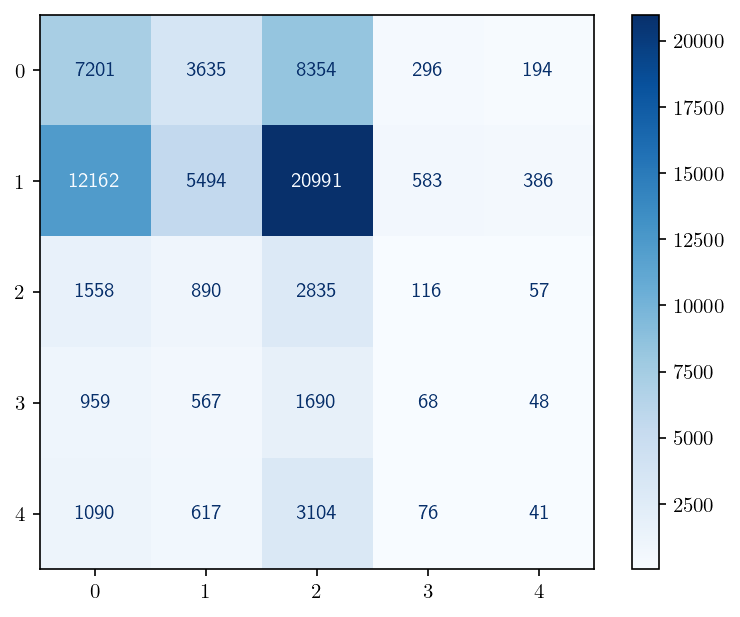

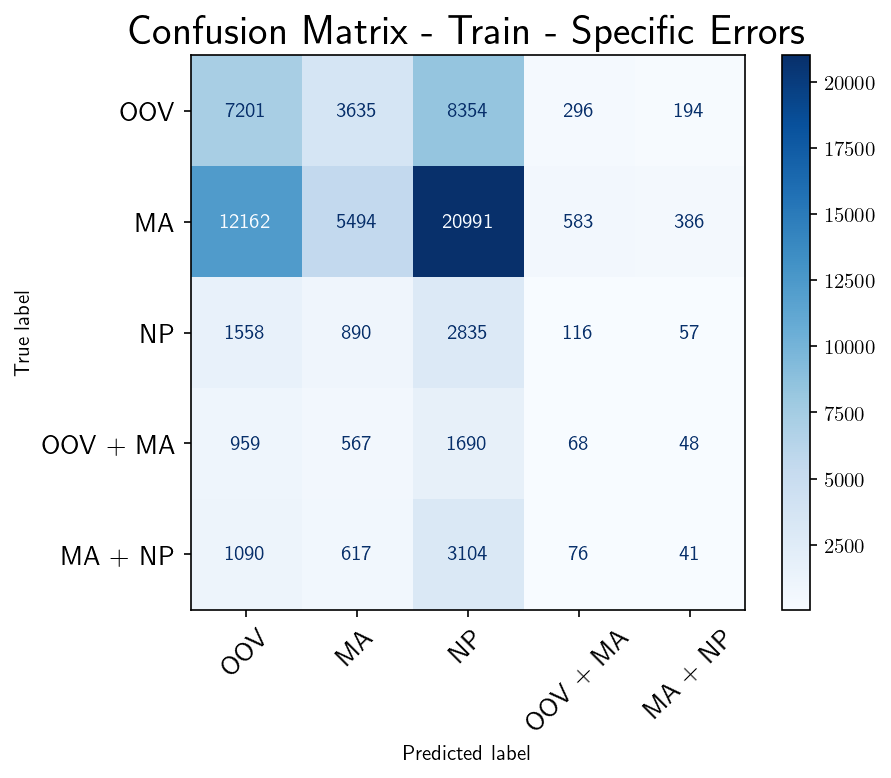

Confusion Matrix for Test:


<Figure size 2250x2250 with 0 Axes>

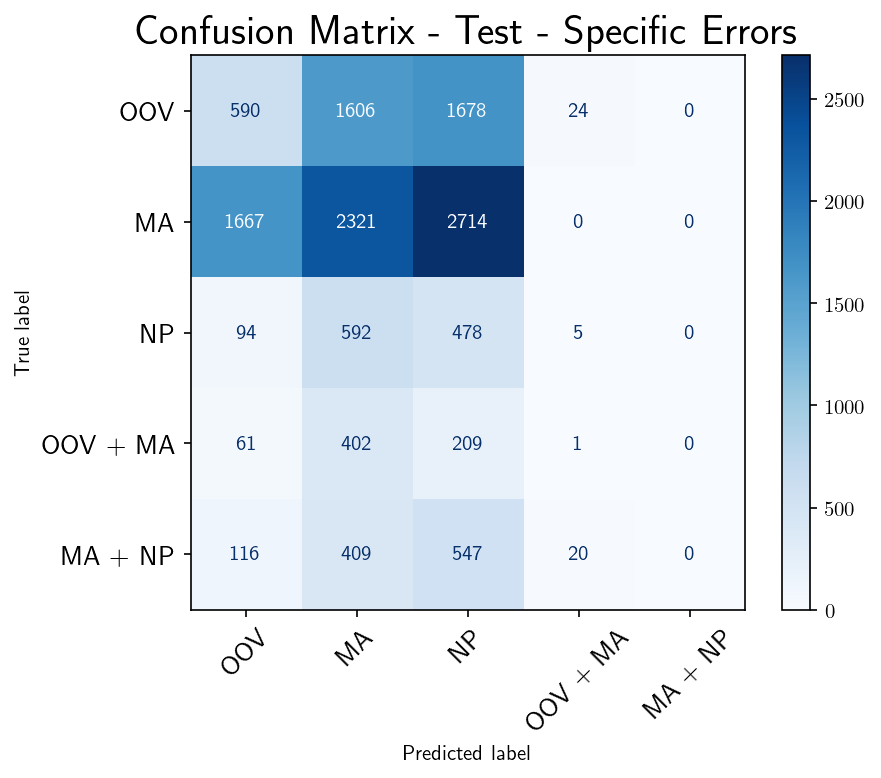

All Errors Summary DataFrame:


,F1,Accuracy,Jaccard,Train Time,Inference Rate
Train,0.285 ± 0.017,0.576 ± 0.029,0.234 ± 0.012,33.80 ± 1.72,NaN
Test,0.173 ± 0.011,0.375 ± 0.069,0.114 ± 0.010,NaN,2.12 ± 0.25


Confusion Matrix for Train:
Confusion Matrix for Train:


<Figure size 2250x2250 with 0 Axes>

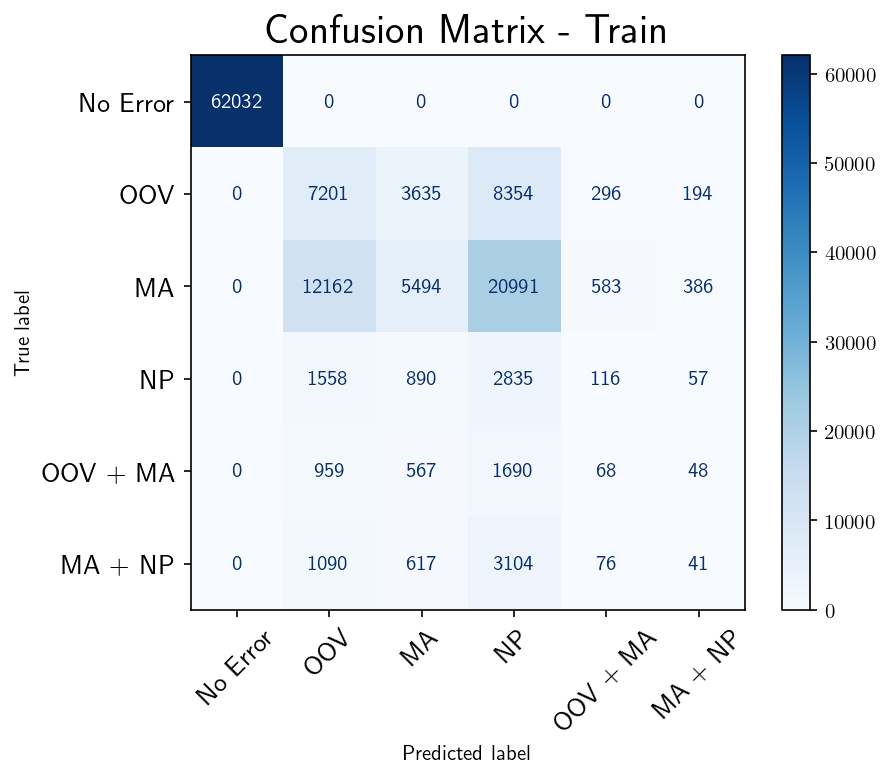

Confusion Matrix for Test:


<Figure size 2250x2250 with 0 Axes>

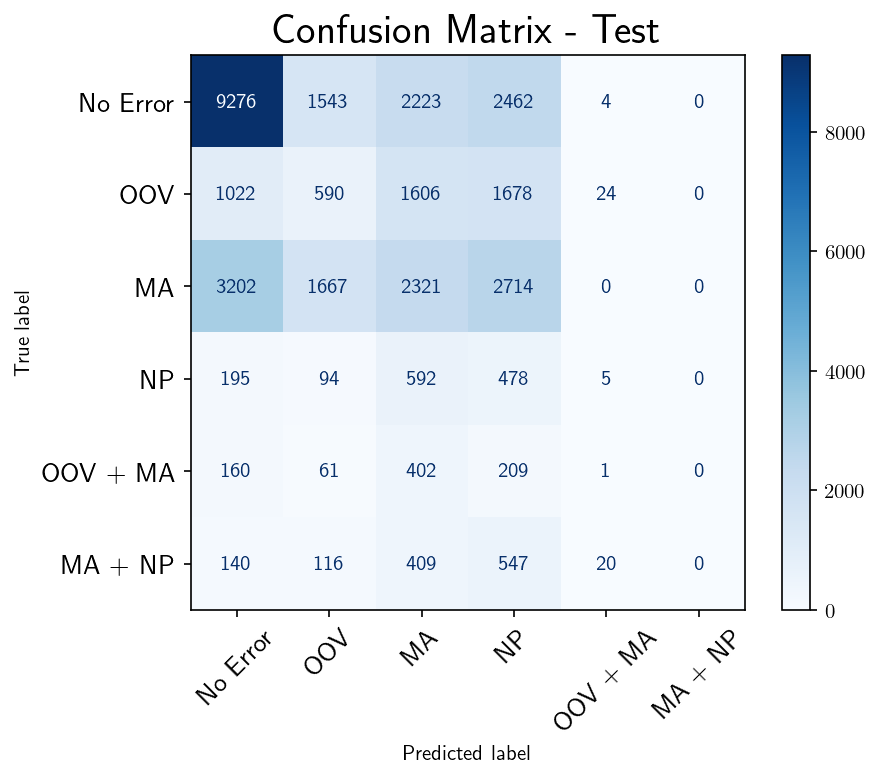

In [3]:
run_id = "f32797cfb1ee4566bff78ca230342bde"
outs = ['1out', '2Out', '3out', '4out', '5out']
setting = 'LOSO'

LOSO_f1_train, LOSO_f1_test, LOSO_f1_train_specific, LOSO_f1_test_specific, LOSO_f1_train_specific_weighted, LOSO_f1_test_specific_weighted, \
LOSO_acc_train, LOSO_acc_test, LOSO_acc_train_specific, LOSO_acc_test_specific,LOSO_jaccard_train, LOSO_jaccard_test,\
LOSO_jaccard_train_specific, LOSO_jaccard_test_specific, LOSO_jaccard_train_specific_weighted, LOSO_jaccard_test_specific_weighted, \
LOSO_cm_train, LOSO_cm_test, LOSO_cm_train_specific, LOSO_cm_test_specific, test_all_preds, test_all_preds_specific, test_all_probs, test_all_labels, \
test_all_labels_specific, test_all_gest_labels, test_all_subjects = retrieve_results_mlflow_sequential(outs=outs,
                                                                                    exp_kwargs=exp_kwargs,
                                                                                    setting=setting,
                                                                                    run_id=run_id)

samples_train = [54, 55, 53, 52, 54]
samples_test = [8303, 6056, 7040, 6929, 5433]
inference_rates = [2.4634459203341192, 1.7261551421822854, 2.0926293163072494, 2.3024287444866256, 2.0045743738129786]
train_times = [36.22828688621521, 35.2961101770401, 33.080938935279846, 31.489164900779723, 32.92548167705536]

#Compute only-error specific metrics
summary_df_specific = create_summary_df(LOSO_f1_train=LOSO_f1_train_specific, LOSO_f1_test=LOSO_f1_test_specific, LOSO_acc_train=LOSO_acc_train_specific,
                                    LOSO_acc_test=LOSO_acc_test_specific, LOSO_jaccard_train=LOSO_jaccard_train_specific, LOSO_jaccard_test=LOSO_jaccard_test_specific,
                                    samples_train=samples_train, samples_test=samples_test,inference_rates=inference_rates, train_times=train_times)

#Save binary summary df to csv
print("Error Specific Summary DataFrame:")
display(summary_df_specific)
summary_df_specific.to_csv(os.path.join(results_folder, 'LOSO_summary_df_specific.csv'), index=False)

#Compute error-specific cm
plot_cm(LOSO_cm_train = LOSO_cm_train_specific, LOSO_cm_test= LOSO_cm_test_specific, image_folder=image_folder, labels =['OOV', 'MA', 'NP', 'OOV + MA', 'MA + NP'])

#Compute all error metrics
summary_df_all = create_summary_df(LOSO_f1_train=LOSO_f1_train, LOSO_f1_test=LOSO_f1_test, LOSO_acc_train=LOSO_acc_train,
                                    LOSO_acc_test=LOSO_acc_test, LOSO_jaccard_train=LOSO_jaccard_train, LOSO_jaccard_test=LOSO_jaccard_test,
                                    samples_train=samples_train, samples_test=samples_test,inference_rates=inference_rates, train_times=train_times)

#Save summary df to csv
print("All Errors Summary DataFrame:")
display(summary_df_all)
summary_df_all.to_csv(os.path.join(results_folder, 'LOSO_summary_df.csv'), index=False)

print("Confusion Matrix for Train:")
plot_cm(LOSO_cm_train = LOSO_cm_train, LOSO_cm_test= LOSO_cm_test, image_folder=image_folder)

Window Summary DataFrame:


,F1,Accuracy,Jaccard
Windowed Metrics,0.360 ± 0.058,0.356 ± 0.060,0.243 ± 0.052


<Figure size 1000x1000 with 0 Axes>

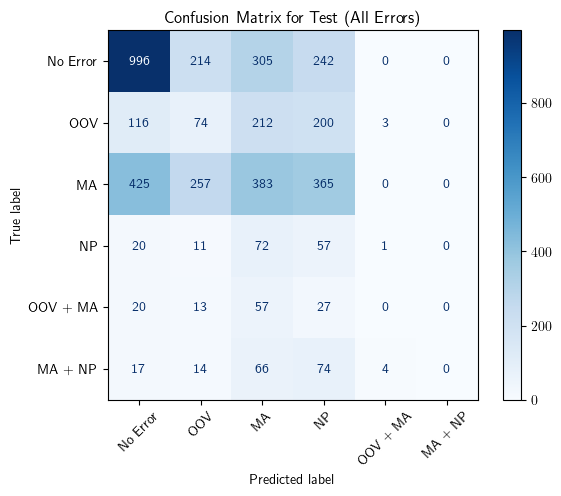

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
window_size, stride = compute_window_size_stride(frequency=exp_kwargs['frequency'])
"""
#a. Error-specific metrics 
summary_df_window_specific, cm_window_test_specific = compute_window_metrics(outs= outs,
                                                           test_all_preds= test_all_preds_specific,
                                                            test_all_labels= test_all_labels_specific,
                                                            test_all_gest_labels= test_all_gest_labels,
                                                            test_all_subjects= test_all_subjects,
                                                            window_size=window_size,
                                                            stride=stride,
                                                            binary=True)


print("Binary Window Summary DataFrame:")
display(summary_df_window_specific)
#summary_df_window.to_csv(os.path.join(results_folder, 'LOSO_summary_df_window.csv'), index=False)

#Plot CM test

plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix=cm_window_test_specific, display_labels=['No Error', 'Error']).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test (Binary)")
plt.show()
"""
#b. All error metrics
summary_df_window, cm_window_test = compute_window_metrics(outs= outs,
                                                            test_all_preds= test_all_preds,
                                                            test_all_labels= test_all_labels,
                                                            test_all_gest_labels= test_all_gest_labels,
                                                            test_all_subjects= test_all_subjects,
                                                            window_size=window_size,
                                                            stride=stride,
                                                            binary=False)

print("Window Summary DataFrame:")
display(summary_df_window)
#summary_df_window.to_csv(os.path.join(results_folder, 'LOSO_summary_df_window.csv'), index=False)

#Plot CM test
plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix=cm_window_test, display_labels=['No Error', 'OOV', 'MA', 'NP', 'OOV + MA', 'MA + NP']).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test (All Errors)")
plt.xticks(rotation=45)
plt.show()